# Analysis of multimodal deep learning for medical images

Initialize by importing all required libraries

In [29]:
# for fetching data
import urllib.parse
import requests
!pip install xmltodict
import xmltodict
import pandas as pd
import time
from tqdm import tqdm

# for preprocessing
import spacy
!pip install scispacy
import scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz

# for embeddings
from sentence_transformers import SentenceTransformer

# for topic modelling/clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from collections import Counter

# for cluster analysis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz (14.8 MB)
  Preparing metadata (setup.py) ... done


## Fetch

In [30]:
def arxiv_fetch(query, max_res_per_query = 1000, batch_size = 100, num_iterations = 10):
    """
    queries: List of search queries
    max_results_per_query: maximum results to fetch per query
    batch_size: number of results per API call (max 100 according to ArXiv rules)

    Returns:
        pd.DataFrame: DataFrame containing all unique paper data
    """
    base_url = 'http://export.arxiv.org/api/query?'
    papers = []

    for q in query:
        search_query = urllib.parse.quote(q) # parse the search word query

        for i in tqdm(range(num_iterations), desc=f"Fetching {q}"):
            # full url of API fetch
            url = f"{base_url}search_query={search_query}&start={0}&max_results={1000}&sortBy=submittedDate&sortOrder=descending"

            try:
                response = requests.get(url) # fetch
                response.raise_for_status() # raise HTTPerror if fetch doesnt work
                data = xmltodict.parse(response.text) # parse fetched data to a dictionary

                entries = data['feed'].get('entry', []) # get list of papers
                entries = [entries] if not isinstance(entries, list) else entries # ensures a single paper fetch is a list as well

                # extract the columns of interest and append
                for entry in entries:
                    paper = {
                        'title': entry['title'].replace('\n', ' ').strip(),
                        'abstract': entry['summary'].replace('\n', ' ').strip(),
                        'published': entry['published'][:10],
                    }

                    papers.append(paper)

                # ArXiv API rate limit: 3 second delay between requests
                time.sleep(3)
            # error handling
            except Exception:
                print(f"Error fetching ArXiv papers for query '{query}'")
                continue

    # convert to DataFrame and remove duplicates
    df = pd.DataFrame(papers)
    df = df.drop_duplicates(subset=['title'])

    return df


# queries based on keyword search
queries = [
    '(intermediate fusion OR early fusion OR late fusion OR hybrid fusion OR feature fusion) AND (medical imaging OR healthcare)',
    '(multimodal OR cross-modal OR multi-stream) AND (MRI OR CT OR X-Ray OR PET OR Ultrasound OR DICOM)',
    '(transformer OR self-attention OR cross-attention OR multi-head attention) AND (medical imaging OR healthcare)',
    '(vision-language OR multi-modal) AND (medical diagnosis OR clinical)',
    '(deep learning OR neural network) AND (multimodal fusion OR cross-modal fusion) AND medical'
]

df_papers = arxiv_fetch(queries)

print(f"\nTotal papers collected: {len(df_papers)}")

Fetching (intermediate fusion OR early fusion OR late fusion OR hybrid fusion OR feature fusion) AND (medical imaging OR healthcare): 100%|██████████| 10/10 [01:00<00:00,  6.07s/it]
Fetching (multimodal OR cross-modal OR multi-stream) AND (MRI OR CT OR X-Ray OR PET OR Ultrasound OR DICOM): 100%|██████████| 10/10 [00:57<00:00,  5.74s/it]
Fetching (transformer OR self-attention OR cross-attention OR multi-head attention) AND (medical imaging OR healthcare): 100%|██████████| 10/10 [01:13<00:00,  7.34s/it]
Fetching (vision-language OR multi-modal) AND (medical diagnosis OR clinical): 100%|██████████| 10/10 [00:32<00:00,  3.25s/it]
Fetching (deep learning OR neural network) AND (multimodal fusion OR cross-modal fusion) AND medical: 100%|██████████| 10/10 [01:20<00:00,  8.01s/it]


Total papers collected: 2985


In [31]:
df_papers.head()

,title,abstract,published
0,SRE-Conv: Symmetric Rotation Equivariant Convo...,Convolutional neural networks (CNNs) are essen...,2025-01-16
1,Improvement of Data Analytics Techniques in Re...,Perovskite oxides such as LaFeO$_3$ are a well...,2025-01-16
2,Fine-Grained Image-Text Correspondence with Co...,Open-Vocabulary Part Segmentation (OVPS) is an...,2025-01-16
3,Undulatory underwater swimming: Linking vortex...,Flapping-based propulsive systems rely on flui...,2025-01-16
4,WMamba: Wavelet-based Mamba for Face Forgery D...,With the rapid advancement of deepfake generat...,2025-01-16


## Preprocessing

In [32]:
nlp = spacy.load("en_core_sci_sm") # scispacy for biomedical preprocessing of data


def preprocess_text(text):

    doc = nlp(text.lower())

    words = []
    for token in doc:
      if token.ent_type_: # named entities in the corpus are always kept
            words.append(token.text)
      # for non-entities preprocess as usual for punctuation, space, word length and stopword
      elif (not token.is_punct and not token.is_space and
              len(token.text) > 2 and not token.is_stop and token.text not in custom_stopwords):
            words.append(token.text)

    return ' '.join(words)

# apply preprocessing on abstract
df_papers['processed_text'] = df_papers['abstract'].apply(preprocess_text)

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


## Feature extraction

In [33]:
# initialize SciBERT model which is optimized for scientific text
# https://huggingface.co/allenai/scibert_scivocab_uncased
model = SentenceTransformer('allenai/scibert_scivocab_uncased')

# generate embeddings
embeddings = model.encode(df_papers['processed_text'].tolist())

## Topic modelling & clustering

In [34]:
def model_topics(embeddings, n_topics):

    # fit k-means on SciBERT embeddings
    kmeans = KMeans(n_clusters=n_topics, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)

    # get top terms for each cluster
    topics = []
    for i in range(n_topics):
        # get indices of documents in this cluster
        cluster_docs = df_papers['processed_text'][cluster_labels == i]

        # get 10 most common terms in cluster
        cluster_text = ' '.join(cluster_docs)
        words = cluster_text.split()
        word_freq = Counter(words).most_common(10)

        topics.append(word_freq)

    return kmeans, topics, cluster_labels

# find optimal number of topics using silhouette score
silhouette_scores = []
K = range(3, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    silhouette_scores.append(score)

optimal_topics = K[np.argmax(silhouette_scores)]

# create and print topics
kmeans, topics, labels = model_topics(embeddings, n_topics=optimal_topics)

for idx, topic_words in enumerate(topics):
    print(f"\nTopic {idx + 1}:")
    print(", ".join([f"{word}({count})" for word, count in topic_words]))


Topic 1:
image(1627), data(1537), model(1478), images(1340), models(1197), features(1056), medical(1052), segmentation(1037), learning(1002), methods(957)

Topic 2:
data(1036), image(908), images(749), models(733), model(719), medical(655), learning(619), multimodal(559), imaging(464), features(456)

Topic 3:
image(838), model(609), data(551), images(549), medical(537), segmentation(535), models(519), methods(503), learning(479), features(457)


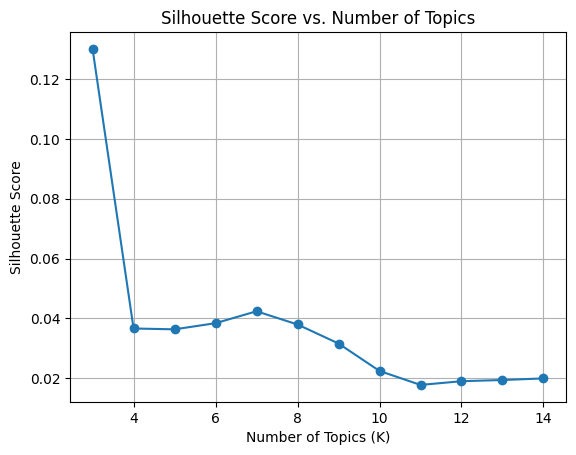

In [36]:

# plot the silhouette scores
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('Number of Topics (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Topics')
plt.grid(True)
plt.show()

All topics contain "deep" which makes sense as deep learning is in all queries. Otherwise, the first topic seems to be heavy on electronics focused applications. AGN, galaxy, galaxies, perhaps mass, are all related to space, while x-ray, emission, radio are all electronics within medical.

Topic 2, 3 and 4 share many common themes regarding medical imaging and should be close to each other.


## Cluster analysis


Cluster Summaries:

Cluster 0:
Size: 1464 papers
Time span: 1998 - 2025
Key terms: image, data, model, images, models
Representative paper: GLoG-CSUnet: Enhancing Vision Transformers with Adaptable Radiomic   Features for Medical Image Segmentation

Cluster 1:
Size: 917 papers
Time span: 2000 - 2025
Key terms: data, image, images, models, model
Representative paper: Interpretable Auto Window Setting for Deep-Learning-Based CT Analysis

Cluster 2:
Size: 604 papers
Time span: 2013 - 2025
Key terms: image, model, data, images, medical
Representative paper: Self-adaptive vision-language model for 3D segmentation of pulmonary   artery and vein


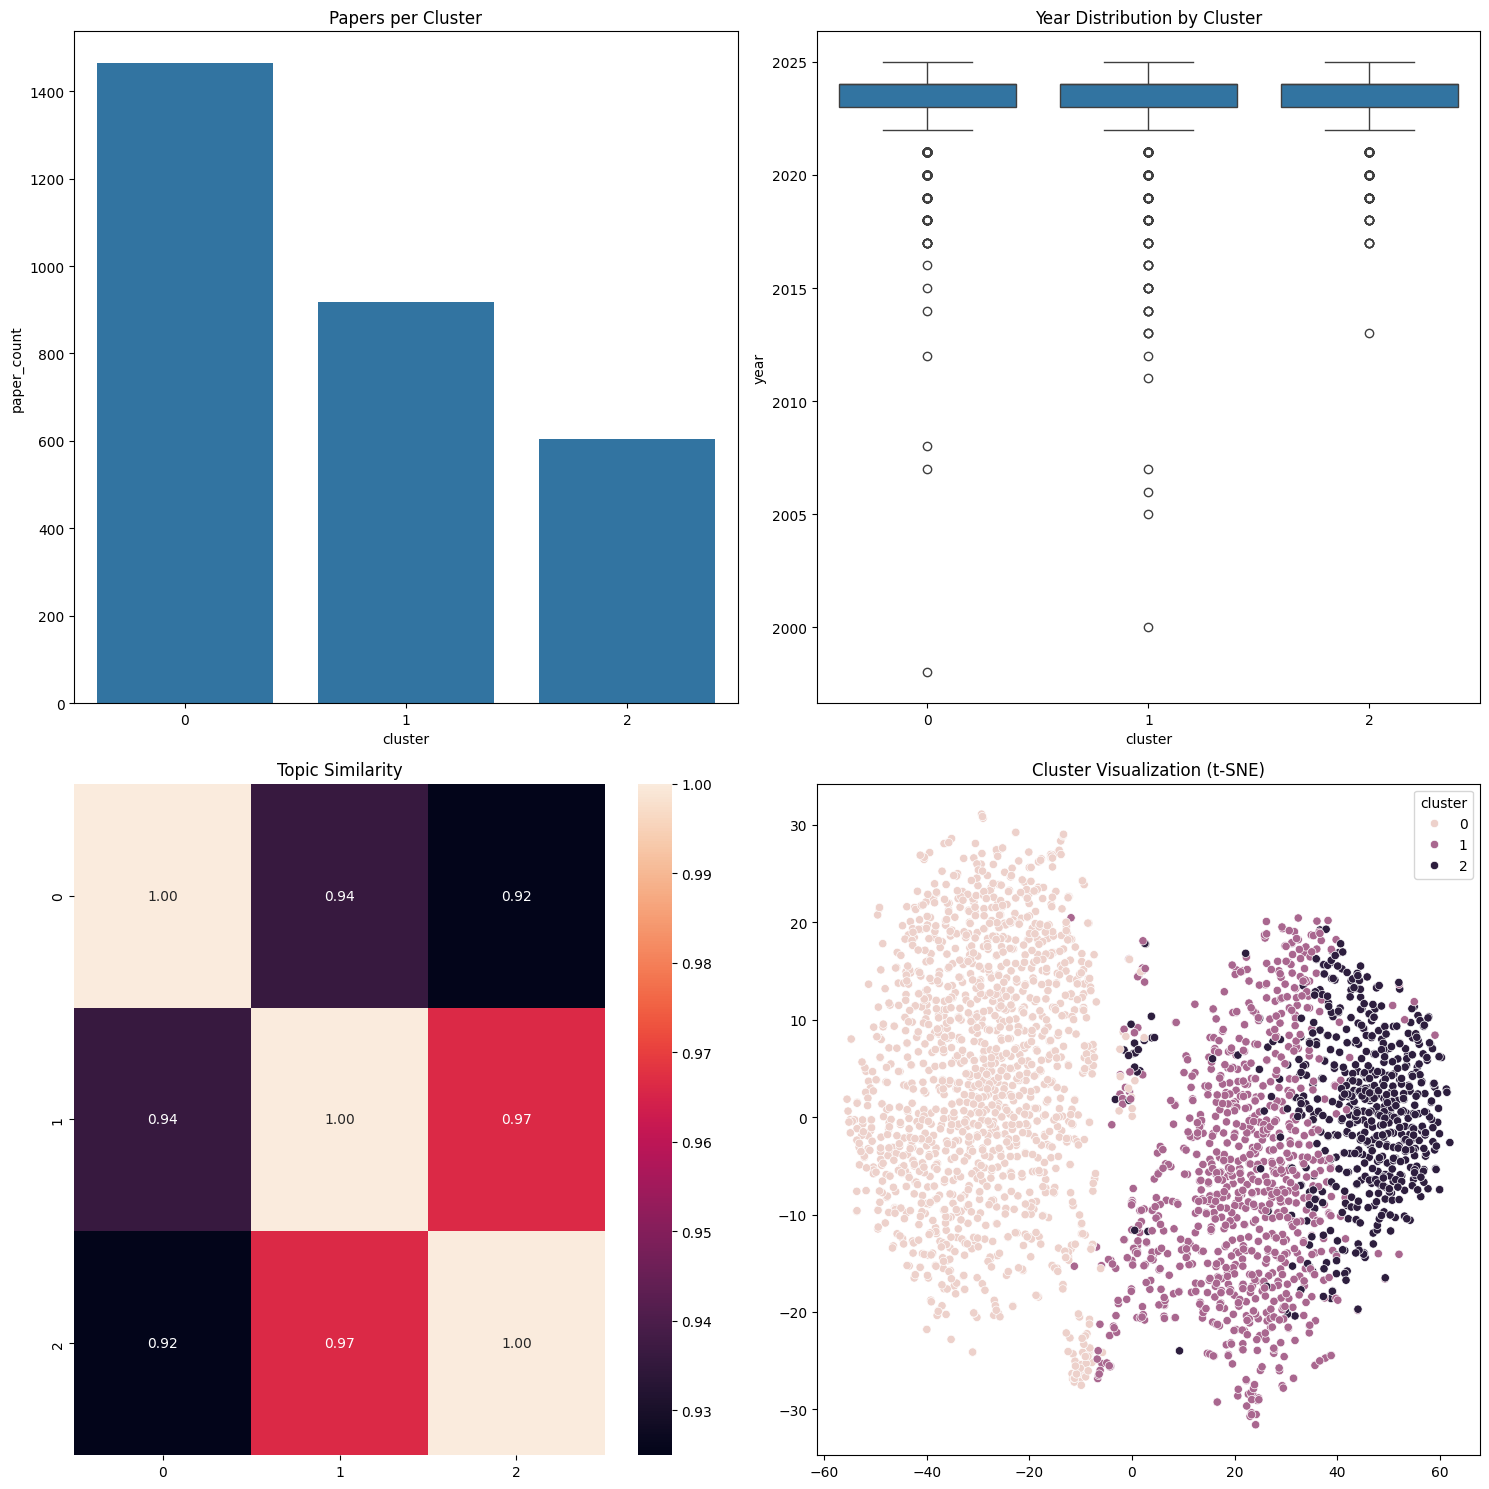

In [35]:
def analyze_clusters(df_papers, kmeans, topics, embeddings):
    # add cluster assignments to the dataframe
    df_papers['cluster'] = labels

    # extract year from published date
    df_papers['year'] = df_papers['published'].str[:4].astype(int)

    # initialize plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    # calculate basic stats for the clusters
    cluster_stats = []

    for cluster_id in sorted(df_papers['cluster'].unique()):
        cluster_papers = df_papers[df_papers['cluster'] == cluster_id]

        stats = {
            'cluster': cluster_id,
            'paper_count': len(cluster_papers),
            'avg_year': cluster_papers['year'].mean(),
            'year_range': (cluster_papers['year'].min(),
                         cluster_papers['year'].max())}

        # get 5 top key terms from topics
        stats['key_terms'] = [term for term, _ in topics[cluster_id][:5]]

        # find representative paper for each cluster i.e. closest to center
        cluster_embeddings = embeddings[df_papers['cluster'] == cluster_id]
        center_dist = np.linalg.norm(cluster_embeddings - kmeans.cluster_centers_[cluster_id], axis=1)
        stats['representative_paper'] = cluster_papers.iloc[center_dist.argmin()]['title']

        cluster_stats.append(stats)

    stats_df = pd.DataFrame(cluster_stats)

    # visualizations
    # cluster size
    sns.barplot(
        data=stats_df,
        x='cluster',
        y='paper_count',
        ax=axes[0,0]
    )
    axes[0,0].set_title('Papers per Cluster')

    # year distributions
    sns.boxplot(
        data=df_papers,
        x='cluster',
        y='year',
        ax=axes[0,1]
    )
    axes[0,1].set_title('Year Distribution by Cluster')

    # topic similarities
    similarity_matrix = cosine_similarity(kmeans.cluster_centers_)
    sns.heatmap(
        similarity_matrix,
        annot=True,
        fmt='.2f',
        ax=axes[1,0]
    )
    axes[1,0].set_title('Topic Similarity')

    # TSNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    sns.scatterplot(
        x=embeddings_2d[:,0],
        y=embeddings_2d[:,1],
        hue=df_papers['cluster'],
        ax=axes[1,1]
    )
    axes[1,1].set_title('Cluster Visualization (t-SNE)')

    plt.tight_layout()

    # cluster summaries
    print("\nCluster Summaries:")
    for stats in cluster_stats:
        print(f"\nCluster {stats['cluster']}:")
        print(f"Size: {stats['paper_count']} papers")
        print(f"Time span: {stats['year_range'][0]} - {stats['year_range'][1]}")
        print(f"Key terms: {', '.join(stats['key_terms'])}")
        print(f"Representative paper: {stats['representative_paper']}")

    return stats_df

stats_df = analyze_clusters(df_papers, kmeans, topics, embeddings)